
# Beating the bookies : a step further

In 2017, KAUNITZ Lisandro, ZHONG Shenjun and KREINER Javier published an article called "Beating the bookies with their own numbers-and how the online sports betting market is rigged" link: https://arxiv.org/pdf/1710.02824.pdf

In this article, they describe how online bookmakers have exceptionnal models to predict games outcomes before they are played, and that they use these models to select the odds they will provide to the public to bet on.

Their theory was that we, as sports gamblers, could take advantage of that, and the fact that different companies have different models, to find outliers in odd distribution and bet on those.
I'll let you read the paper if you want more details.

So, in this notebook, we will try to go a step further. Their method is based on the closing odds given right before a game starts. But what if we could predict which games will have outliers in their odds distribution before the odds are even dealt ? What if we could accurately predict which game to bet on based on previous ones ?

Let's find out !

NB: This is my second attempt at this exercise. This notebook contains the full exercise, with EDA and all. If you want to streamline the correction and go straight to the point, you can find the modelling notebook in the folder.

Let's dive in.

In [1]:
import pandas as pd
from matplotlib import pyplot as pl
import numpy as np
import seaborn as sns

C:\Users\remib\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\remib\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\remib\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The data we will be using comes from the authors kaggle dataset. Link here : https://www.kaggle.com/datasets/austro/beat-the-bookie-worldwide-football-dataset

In [2]:
Closing_Odds_df = pd.read_csv("closing_odds.csv")
Closing_Odds=Closing_Odds_df.copy()
Closing_Odds

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,1.6122,3.4133,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,5.9878,3.4778,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World: Club Friendly,2015-06-30,St. Gallen,1,Wacker Innsbruck,2,1.6838,3.8846,3.9813,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24
479436,876807,World: Club Friendly,2015-06-30,SW Harelbeke,1,Waregem,1,13.1165,7.8229,1.1053,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17
479437,876808,World: Club Friendly,2015-06-30,Torhout,0,Club Brugge,5,17.2256,12.6231,1.0288,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16
479438,876809,World: Club Friendly,2015-06-30,Tournai,0,Mouscron Peruwelz,3,15.7143,10.2857,1.0614,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7


# PLAN :

### I - Overall exploratory analysis of the data
- Distribution of results and goals
- Year by Year analysis
- Bookmaker companies analysis
- Geographical (leagues/countries) analysis

### II - Introduction of the paper's strategy
- Second overall analysis based on the paper's inputs
- Feature Engineering

### III - Model
- Model choice and training
- Results evaluations and conclusions


Before we develop a model and dive deep into the paper's strategy, we should get comfortable with our data, try to anticipate potential biases in the data collection, highlight tendencies and detect data that need cleaning/transforming.


# I - Overall exploratory analysis 

First, we add result column to the dataset, to save us time when checking game outcomes. 

In [3]:
result = 1 * (Closing_Odds['home_score'] > Closing_Odds['away_score']) \
       - 1 * (Closing_Odds['home_score'] < Closing_Odds['away_score'])
        # + 0 * (Closing_Odds['home_score'] == Closing_Odds['away_score'])

#My result column : 1 for HomeWin, 0 for Draw and -1 for AwayWin

    
Closing_Odds.insert(7 ,'result' , result)

Closing_Odds

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
0,170088,England: Premier League,2005-01-01,Liverpool,0,Chelsea,1,-1,2.9944,3.1944,2.2256,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9
1,170089,England: Premier League,2005-01-01,Fulham,3,Crystal Palace,1,1,1.9456,3.2333,3.6722,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9
2,170090,England: Premier League,2005-01-01,Aston Villa,1,Blackburn,0,1,1.8522,3.2611,4.0144,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9
3,170091,England: Premier League,2005-01-01,Bolton,1,West Brom,1,0,1.6122,3.4133,5.4722,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9
4,170092,England: Premier League,2005-01-01,Charlton,1,Arsenal,3,-1,5.9878,3.4778,1.5567,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World: Club Friendly,2015-06-30,St. Gallen,1,Wacker Innsbruck,2,-1,1.6838,3.8846,3.9813,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24
479436,876807,World: Club Friendly,2015-06-30,SW Harelbeke,1,Waregem,1,0,13.1165,7.8229,1.1053,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17
479437,876808,World: Club Friendly,2015-06-30,Torhout,0,Club Brugge,5,-1,17.2256,12.6231,1.0288,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16
479438,876809,World: Club Friendly,2015-06-30,Tournai,0,Mouscron Peruwelz,3,-1,15.7143,10.2857,1.0614,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7


[45.241114633739365, 24.98644251626898, 29.772442849991656]


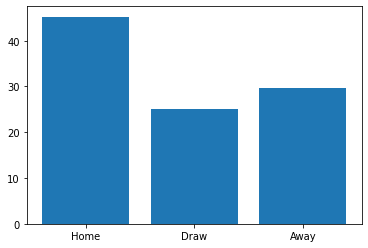

In [4]:
X = ['Home','Draw','Away']
Y = [100*len(Closing_Odds[Closing_Odds['result']>0])/len(Closing_Odds),
     100*len(Closing_Odds[Closing_Odds['result']==0])/len(Closing_Odds),
     100*len(Closing_Odds[Closing_Odds['result']<0])/len(Closing_Odds)]
print(Y)
pl.bar(X,Y)
pl.show()

45% of games end with the home team winning, ~25% end in draw and ~30% with the away team winning.

Onto goals now

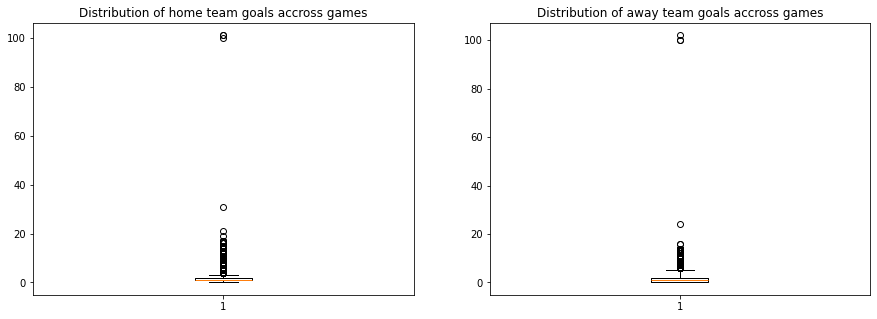

In [5]:
fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))

ax1.boxplot(list(Closing_Odds['home_score']))
ax2.boxplot(list(Closing_Odds['away_score']))

ax1.set_title('Distribution of home team goals accross games')
ax2.set_title('Distribution of away team goals accross games')

pl.show()

Well well well, 100 goals scored in one game, better check that out.

In [6]:
Closing_Odds[Closing_Odds['home_score']>30]

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
10773,196028,Mexico: Primera Division,2005-08-13,Necaxa,101,U.N.A.M.- Pumas,0,1,2.1433,3.2117,2.9033,2.20,3.30,3.00,Expekt,William Hill,bet365,6,6,6
60099,293927,Peru: Primera Division,2007-08-26,Alianza Atl.,101,Sport Ancash,1,1,1.9244,3.1922,3.4478,2.00,3.20,3.50,bwin,bet-at-home,bet365,9,9,9
97404,362716,France: Coupe de France,2008-11-22,Haguenau,100,Dijon,102,-1,7.9891,3.9755,1.3536,9.00,4.00,1.37,Betclic,bet-at-home,Expekt,11,11,11
280577,617953,Romania: Romanian Cup,2012-08-28,Berceni,31,Academica Arges,0,1,1.7300,3.7500,3.7500,1.73,3.75,3.75,Paddy Power,Paddy Power,Paddy Power,1,1,1


In [7]:
Closing_Odds[Closing_Odds['away_score']>20]

,match_id,league,match_date,home_team,home_score,away_team,away_score,result,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
30817,236985,Peru: Primera Division,2006-05-24,FBC Melgar,1,Jose Galvez,100,-1,2.1000,3.2000,3.0000,2.1,3.2,3.00,bet365,bet365,bet365,1,1,1
97404,362716,France: Coupe de France,2008-11-22,Haguenau,100,Dijon,102,-1,7.9891,3.9755,1.3536,9.0,4.0,1.37,Betclic,bet-at-home,Expekt,11,11,11
97409,362731,France: Coupe de France,2008-11-22,Saint-Omer,0,Amiens,100,-1,11.4489,5.6500,1.1700,14.0,6.0,1.26,Betsafe,bet365,10Bet,9,9,9
250126,579115,South Africa: Nedbank Cup,2012-03-04,Powerlines,0,Mamelodi Sundowns,24,-1,17.7500,7.1250,1.1000,19.0,7.5,1.11,Sportingbet,Sportingbet,bwin,4,4,4


After review :
- Necaxa - U.N.A.M. ended 2-0, 
- Alianza Atl. - Sport Ancash ended on a 1-1
- Haguenau - Dijon ended in a 0-1
- Berceni - Academica Arges really ended 31-0

- FBC Melgar - Jose Galvez ended on a 2-0
- Saint-Omer - Amiens ended 1-0
- Powerlines - Mamelodi Sundowns really ended 0-24

Let's correct the dataset's mistake and go from there

In [8]:
Closing_Odds.loc[10773,'home_score']=2
Closing_Odds.loc[10773,'away_score']=0

Closing_Odds.loc[60099,'home_score']=1
Closing_Odds.loc[60099,'away_score']=1

Closing_Odds.loc[97404,'home_score']=0
Closing_Odds.loc[97404,'away_score']=1

Closing_Odds.loc[30817,'home_score']=2
Closing_Odds.loc[30817,'away_score']=0

Closing_Odds.loc[97409,'home_score']=1
Closing_Odds.loc[97409,'away_score']=0

#Update result column
result_col = 1 * (Closing_Odds['home_score'] > Closing_Odds['away_score']) \
       - 1 * (Closing_Odds['home_score'] < Closing_Odds['away_score'])

Closing_Odds['result'] = result_col

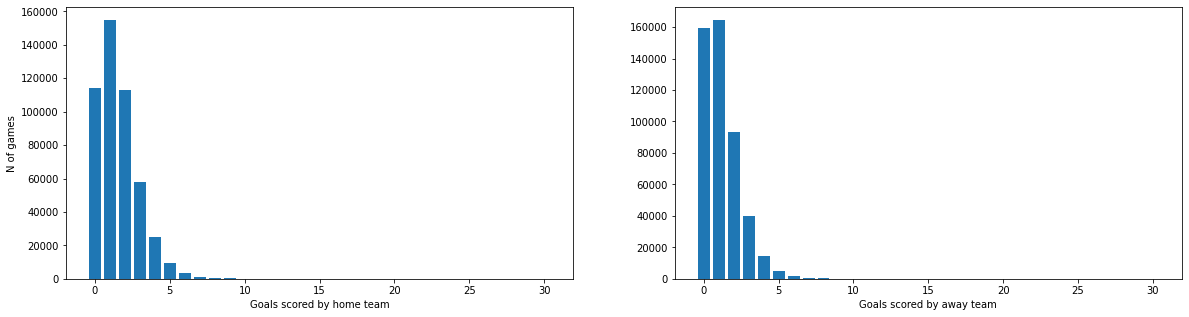

 Home teams score 1.538 goals on average, while away teams only score 1.2


In [9]:
X = range(max(Closing_Odds["home_score"]))
YH = []
YA = []

for x in X: 
    YH.append(len(Closing_Odds[Closing_Odds["home_score"]==x]))
    
for x in X:    
    YA.append(len(Closing_Odds[Closing_Odds["away_score"]==x])) 
 

fig,(ax1,ax2) = pl.subplots(1,2, figsize=(20,5))

ax1.bar(X,YH)
ax1.set_xlabel('Goals scored by home team')
ax1.set_ylabel('N of games')
ax2.bar(X,YA)
ax2.set_xlabel('Goals scored by away team')

pl.show()

print(f" Home teams score {round(np.mean(Closing_Odds['home_score']),3)} goals on average, while away teams only score {round(np.mean(Closing_Odds['away_score']),3)}")

#### - Year to year analysis : distribution of bets placed per year, and increase of competition in bookmakers

In [10]:
YEAR = []
for date in list(Closing_Odds["match_date"]):
   YEAR.append(int(date[:4]))

Closing_Odds.insert(3,'year',YEAR)

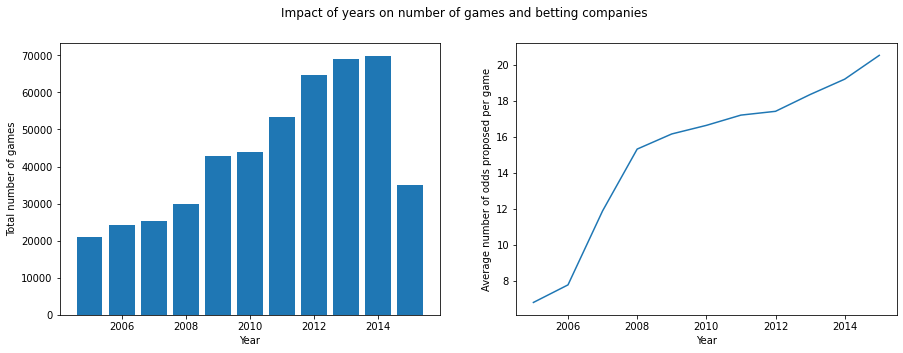

In [11]:
X = range(2005,2016)
Y1 = []
Y2 = []

for x in X:
    
    yearly_df = Closing_Odds[Closing_Odds["year"]==x]
    
    Y1.append(len(yearly_df))
    Y2.append(np.mean(yearly_df['n_odds_home_win'])) #Same averages for H/D/A in number of odds available.

fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))

fig.suptitle("Impact of years on number of games and betting companies")
ax1.bar(X,Y1)
ax1.set_ylabel("Total number of games")
ax1.set_xlabel("Year")

ax2.plot(X,Y2)
ax2.set_ylabel("Average number of odds proposed per game")
ax2.set_xlabel("Year")
pl.show()

Important to keep in mind : we have more games available in 2012 2013 and 2014 than any other years, by quite a large margin. 2005 to 2008 and 2015 are less filled.

Also, as we expected, there is an increase in odds available to chose from as years progress. Let's see if competition has an impact on those numbers.

#### - Betting companies : who's the most advantageous to bet on ? The least ?

Before looking at games with high amount of odds available and selecting the best one, we should look at the number of games with no bets available for one or more outcomes. Because it might give us some problem down the road.

In [12]:
pd.concat([Closing_Odds[Closing_Odds["n_odds_home_win"]==0],Closing_Odds[Closing_Odds["n_odds_away_win"]==0]]).head()

,match_id,league,match_date,year,home_team,home_score,away_team,away_score,result,avg_odds_home_win,...,avg_odds_away_win,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win
7761,188788,Singapore: S-League,2005-05-19,2005,Home Utd,0,Warriors,1,-1,0.0,...,3.4,0.0,3.50,3.4,NaN,bwin,bwin,0,1,1
7762,188789,Singapore: S-League,2005-05-19,2005,Tampines,1,Young Lions,0,1,0.0,...,6.0,0.0,3.75,6.0,NaN,bwin,bwin,0,1,1
9140,192445,Singapore: S-League,2005-06-24,2005,Woodlands W.,2,Young Lions,2,0,0.0,...,5.0,0.0,3.75,5.0,NaN,bwin,bwin,0,1,1
234040,559175,Denmark: Elitedivisionen Women,2011-11-12,2011,Skovbakken W,9,Taastrup W,1,1,0.0,...,30.0,0.0,18.00,30.0,NaN,bet365,bet365,0,1,1
243382,570692,World: Olympic Games Women,2012-01-22,2012,Mexico W,7,Dominican Republic W,0,1,0.0,...,101.0,0.0,41.00,101.0,NaN,bet365,bet365,0,1,1


Games in which there are no odds for Home or Away Teams are very one-sided (so much that a 1.01 odd would still be losing money so better not propose at all). It's a little work around for our data analysis purposes but these games are still valuable and can't be deleted without care. Plus, it's probably an easy prediction to land for our future model. There are 28 instances of 0 bets for H, and 24 for A (none for Draw, you can always bet on draw, what a way to live life)

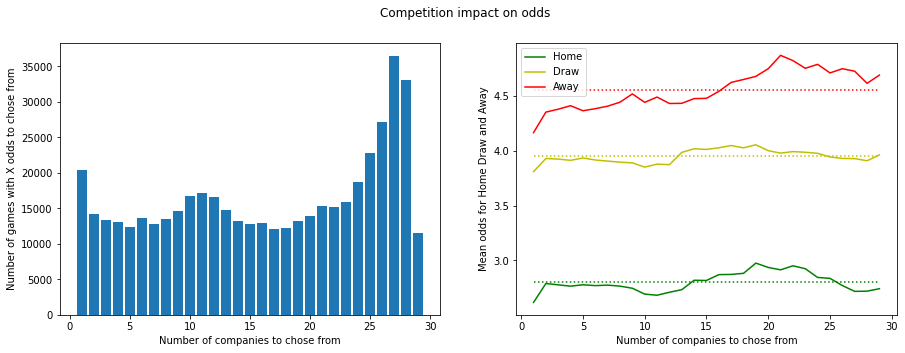

In [13]:
X = list(set(list(Closing_Odds["n_odds_home_win"])))
X=X[1:]
#Delete the 'NaN' occurences when no odds are available for a bet and we get the 29 bookmakers like advertised

Y=[]

H,D,A=[],[],[]
for x in X:
    Competition_df = Closing_Odds[Closing_Odds["n_odds_home_win"]==x]
    Y.append(len(Competition_df)) #Number of games played with X amount of odds to chose from 
    H.append(np.mean(Competition_df['max_odds_home_win'])) #Average odd for Home team Win per number of odds to choose from
    D.append(np.mean(Competition_df['max_odds_draw']))#-------------------- Draw ------------------------------------------
    A.append(np.mean(Competition_df['max_odds_away_win'])) #--------------- Away ------------------------------------------

    
    
fig,(ax1,ax2) = pl.subplots(1,2, figsize=(15,5))
fig.suptitle("Competition impact on odds")

ax1.bar(X,Y)
ax1.set_ylabel("Number of games with X odds to chose from")
ax1.set_xlabel("Number of companies to chose from")

ax2.plot(X,H,c="g", label="Home")
ax2.plot(X,D,c="y", label="Draw")
ax2.plot(X,A,c="r", label="Away")

ax2.hlines(np.mean(H),1,len(X),color='g',linestyle='dotted')
ax2.hlines(np.mean(D),1,len(X),color='y',linestyle='dotted')
ax2.hlines(np.mean(A),1,len(X),color='r',linestyle='dotted')


ax2.set_ylabel("Mean odds for Home Draw and Away")
ax2.set_xlabel("Number of companies to chose from")
ax2.legend()

pl.show()

Most games we collected have between 2 and 23 odds to chose from. Still, we've got plenty of games with 25 odds or more, which is a consequence of the 2 previous graphs we outlined : an increase of games played in 2013+ in our dataset, and the rise in betting companies accross time.

On the second graph, we observe no noticeable change for Home team and Draws, but a slight increase in odds for Away teams as competition rises. That's understandable, the best way for betting companies to separate themselves is by increasing odds of outcomes they deem unlikely, so their bigger numbers attract more clients while still keeping their profit margins relatively untouched.

Now we shall compare bookmakers numbers. Who gives us the best odds the most often ? Who's tightfisted ? 

In [14]:
Bookies = list(set(list(Closing_Odds["top_bookie_home_win"])+list(Closing_Odds["top_bookie_draw"])+list(Closing_Odds["top_bookie_away_win"])))
Bookies=Bookies[1:]



H,D,A=[],[],[]

for bm in Bookies:
    
    H.append(len(Closing_Odds[Closing_Odds["top_bookie_home_win"]==bm]))
    D.append(len(Closing_Odds[Closing_Odds["top_bookie_draw"]==bm]))
    A.append(len(Closing_Odds[Closing_Odds["top_bookie_away_win"]==bm]))

Best_H_BM = {}
Best_D_BM = {}
Best_A_BM = {}
Best_BM = {}

for i in range(len(Bookies)):
    
    Best_H_BM[Bookies[i]] = H[i]
    Best_D_BM[Bookies[i]] = D[i]
    Best_A_BM[Bookies[i]] = A[i]
    Best_BM[Bookies[i]] = H[i]+D[i]+A[i]
    


In [15]:
print("Best Bookmakers : ",sorted(Best_BM.items(), key=lambda x: x[1], reverse=True))
#print("Worst Bookmakers : ",sorted(Best_BM.items(), key=lambda x: x[1], reverse=False))

Best Bookmakers :  [('Pinnacle Sports', 202774), ('bet365', 182756), ('bwin', 131318), ('BetVictor', 91718), ('188BET', 83500), ('10Bet', 65051), ('Sportingbet', 59795), ('Expekt', 52418), ('Betsafe', 50107), ('bet-at-home', 47068), ('12BET', 45146), ('888sport', 41395), ('Tipico', 41160), ('Betway', 33553), ('SBOBET', 32219), ('Paddy Power', 29543), ('Coral', 27143), ('Betclic', 26871), ('Interwetten', 26765), ('Ladbrokes', 23577), ('Unibet', 23388), ('Betsson', 23190), ('William Hill', 23127), ('myBet', 22378), ('DOXXbet', 16224), ('ComeOn', 12172), ('Titanbet', 9503), ('youwin', 8015), ('Jetbull', 6394)]


Pinnacle Sports is the uncontested best bookmaker on the market. In ~480,000 games (meaning ~1,200,000 Odds to chose from), they have one of the best odds 200,000 times. This is quite impressive. 

#### - Geographical data : Where are our games played ? What leagues / countries are the most involved ? Does it have an impact on odds, or results ?

In [16]:
Countries_dict = {}
Leagues_dict = {}

Countries_list = []
Leagues_list = []

for league in list(Closing_Odds["league"]):

    country = league.split(": ")[0]
    Countries_list.append(country)
    Leagues_list.append(league)
    
    if country in Countries_dict:
        Countries_dict[country]+=1
    else:
        Countries_dict[country]=1
        
    if league in Leagues_dict:
        Leagues_dict[league]+=1
    else:
        Leagues_dict[league]=1
        

print(f"{len(Closing_Odds)} games")
print(f"{len(set(Closing_Odds['league']))} different leagues")
print(f"{len(Countries_dict)} different countries")


479440 games
818 different leagues
129 different countries


In [17]:
sorted(Countries_dict.items(), key=lambda x: x[1], reverse=True)[:15]

[('England', 45000),
 ('Germany', 32037),
 ('World', 24402),
 ('Italy', 21920),
 ('Spain', 19171),
 ('Turkey', 14196),
 ('France', 14070),
 ('Europe', 12998),
 ('Norway', 11655),
 ('Russia', 11060),
 ('Denmark', 9752),
 ('Czech Republic', 9002),
 ('Scotland', 8946),
 ('Belgium', 8941),
 ('Austria', 8733)]

In [18]:
sorted(Leagues_dict.items(), key=lambda x: x[1], reverse=True)[:15]

[('World: Club Friendly', 14106),
 ('England: League Two', 5283),
 ('England: League One', 5277),
 ('England: Championship', 5260),
 ('World: Friendly International', 5105),
 ('Italy: Serie B', 4481),
 ('Spain: Segunda Division', 4439),
 ('Argentina: Primera Division', 4024),
 ('Netherlands: Eerste Divisie', 3772),
 ('Italy: Serie A', 3643),
 ('Chile: Primera Division', 3637),
 ('Spain: Primera Division', 3630),
 ('France: Ligue 1', 3609),
 ('France: Ligue 2', 3608),
 ('England: Premier League', 3602)]

We have a huge focus on english football, with 45,000 games to chose from. Second is Germany, with ~32,000 and then there is a big drop, with World, Italy, Spain and France all below 24,000, almost half the amount of English games. 

In terms of leagues, what we have most of is world friendlies. 

I thought it would be beneficial to separate the league column into the 2 separate entities country & league alone, but it wouldn't tell the full story, as some countries have the same league names. For example, almost every spanish speaking country's first division is called 'Primera Division'.
So I will add a country column, just to get the information more accessible, but keep the league column as is.

In [19]:
Closing_Odds.insert(1,'country',Countries_list)

## II - Introduction of the paper's strategy :

Kaunitz, Zhong & Kreiner (2017) develop a way to find the most attractive odds and bet only on positive EV, basing their method on the high propensity for bookmakers' models to accurately predict games results.
Their way of coming to the final formula is highlighted in detail in the paper, for now let's jump right in.

#### Formula (Eq7) :  max(Ω) > 1/pcons - α <=> (1/avg(Ω) - α)*max(Ω) -1 > 0


(If at least 3 odds available, else do not bet)

In [20]:
alpha = 0.05

In [21]:
Home_condition = ((1/Closing_Odds['avg_odds_home_win']-alpha)*Closing_Odds['max_odds_home_win']-1>0)& (Closing_Odds['n_odds_home_win']>3)

Draw_condition = ((1/Closing_Odds['avg_odds_draw']-alpha)*Closing_Odds['max_odds_draw']-1>0)& (Closing_Odds['n_odds_draw']>3)

Away_condition = ((1/Closing_Odds['avg_odds_away_win']-alpha)*Closing_Odds['max_odds_away_win']-1>0)& (Closing_Odds['n_odds_away_win']>3)

In [22]:
#print(100*sum(Home_condition)/len(Closing_Odds),
#      100*sum(Draw_condition)/len(Closing_Odds),
#      100*sum(Away_condition)/len(Closing_Odds))

Condition = Home_condition|Draw_condition|Away_condition

print(100*sum(Condition)/len(Closing_Odds),"% of our games are eligible for our betting strategy")

11.771024528616719 % of our games are eligible for our betting strategy


In [23]:
Closing_Odds['condition'] = Condition
Closing_Odds

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_home_win,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,3.20,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,2.04,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,2.00,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,1.67,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,7.00,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World,World: Club Friendly,2015-06-30,2015,St. Gallen,1,Wacker Innsbruck,2,-1,...,1.83,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24,False
479436,876807,World,World: Club Friendly,2015-06-30,2015,SW Harelbeke,1,Waregem,1,0,...,19.00,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17,False
479437,876808,World,World: Club Friendly,2015-06-30,2015,Torhout,0,Club Brugge,5,-1,...,22.00,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16,False
479438,876809,World,World: Club Friendly,2015-06-30,2015,Tournai,0,Mouscron Peruwelz,3,-1,...,34.00,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7,False


## Feature engineering

Our strategy now consists in finding ways to predict this odd-related condition for new games, without access to odds data.

The first step will be to understand what makes a game likely to fulfill this condition. To do that, we will test our hypothesis against the data we have, and detail our thought process and conclusions.

Then we can add new features to the dataset, hoping it leads to the best predictive model in the end.


### #1 : Number of odds available

As we saw in the EDA part, the competition impact might be our biggest ally in this one. We want to find games that have the most odds to bet on, because it forces bookmakers to differenciate themselves and increases our chance of finding advantageous games to bet on.

For reference, here are the number of odds distribution, with the associated advantageous games in orange. We have to find a way to estimate this feature in our model (because we can't access it right away as it is unavailable for our purposes).

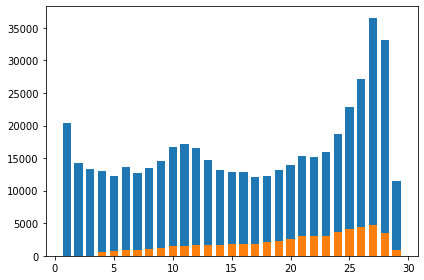

In [24]:
X = range(1,len(Closing_Odds['n_odds_draw'].unique())+1)
Y = Closing_Odds.groupby('n_odds_draw')['condition'].describe()["count"]
Y2 = [0,0,0]+list(Closing_Odds[Closing_Odds['condition']==True].groupby('n_odds_draw')['condition'].describe()["count"])

fig = pl.figure()
ax = fig.add_subplot(111)
ax.bar(x=X, height=Y, width=.7, align='center')
ax.bar(x=X, height=Y2, width=.7, align='center')


pl.tight_layout()
pl.show()

Let's try to estimate the "n_odds_draw" feature, by computing a rolling average sorting games by leagues.

In practice, each game would have a new feature that will entail the average odds available for draw in the last 5 games played in the same league. That way we can approximate the number of odds available to bet on draw for this game, which will then help us deterine the "condition" label with our model.

In [25]:
def get_n_odds_est(df):
    # Sort the DataFrame by league and match_id to ensure chronological order
    df = df.sort_values(by=['league', 'match_id'])
    
    # Group by league and compute the rolling average for 'n_odds_draw'
    rolling_means = (
        df.groupby('league')['n_odds_draw']
        .apply(lambda x: x.rolling(window=5, min_periods=1).mean())
    )
    
    df['n_odds_est'] = rolling_means.reset_index(drop=True)
    
    return df

# Apply the function to the dataframe
Closing_Odds = get_n_odds_est(Closing_Odds)
Closing_Odds.sort_values(by='match_id').reset_index(drop=True)

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_draw,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition,n_odds_est
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,3.25,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False,19.0
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,3.30,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False,14.0
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,3.40,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False,16.0
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,3.57,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False,17.0
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,3.60,1.62,Expekt,Paddy Power,bet365,9,9,9,False,17.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479435,876806,World,World: Club Friendly,2015-06-30,2015,St. Gallen,1,Wacker Innsbruck,2,-1,...,4.20,4.33,188BET,bet365,Ladbrokes,24,24,24,False,12.0
479436,876807,World,World: Club Friendly,2015-06-30,2015,SW Harelbeke,1,Waregem,1,0,...,9.00,1.13,BetVictor,bet365,Titanbet,17,17,17,False,11.8
479437,876808,World,World: Club Friendly,2015-06-30,2015,Torhout,0,Club Brugge,5,-1,...,15.00,1.05,BetVictor,Jetbull,BetVictor,16,16,16,False,11.6
479438,876809,World,World: Club Friendly,2015-06-30,2015,Tournai,0,Mouscron Peruwelz,3,-1,...,12.00,1.10,Sportingbet,Betclic,Paddy Power,7,7,7,False,11.2


How accurate is this estimator ? Can we actually approximate the number of odds available for a game based on the numbe rof odds available for the last 5 league's games ?

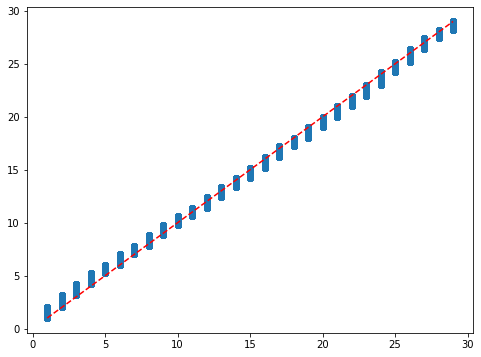

In [26]:
actual = sorted(Closing_Odds["n_odds_draw"])
predicted = sorted(Closing_Odds["n_odds_est"])

pl.figure(figsize=(8, 6))
pl.scatter(actual, predicted, alpha=0.7, label='Predicted vs Actual')

# Ideal line (y = x)
min_val = min(min(actual), min(predicted))
max_val = max(max(actual), max(predicted))
pl.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y=x)')
pl.show()

This graph show us that the estimations (blue ticks) are in the very proximity of the red dotted line (theory of what we should have gotten). Our estimator slightly overestimates low available odds and slightly understimates high available odds.

### #2 : Month of the year

Here is a theory : What if games played at the beginning of the season (aka end of the year) have more variance because teams have spent the last few months not playing. Bookmakers have to guess teams' form, they don't have access to recent games. Maybe it's a good way to find variance in odds distribution, let's see

In [27]:
Closing_Odds["month"] = Closing_Odds["match_date"].apply(lambda date: int(date[5:7]))

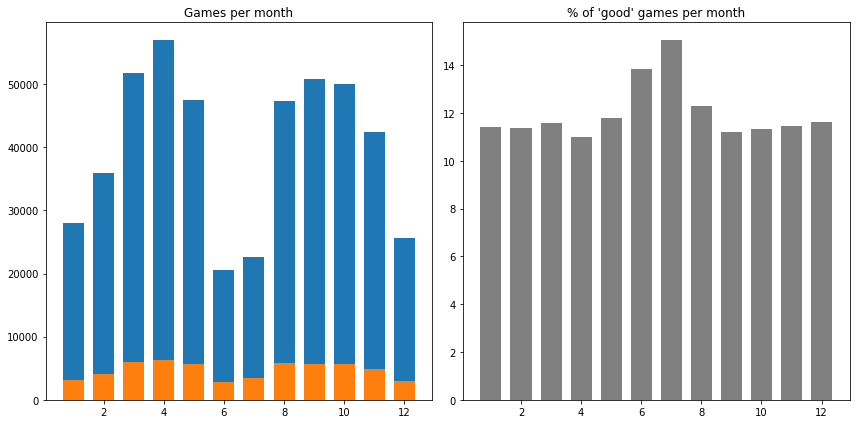

In [28]:
X = range(1, 13)
Y = Closing_Odds.groupby('month')['condition'].describe()["count"]
Y2 = Closing_Odds[Closing_Odds['condition']==True].groupby('month')['condition'].describe()["count"]

ratios = (Y2 / Y) * 100

fig, axes = pl.subplots(1, 2, figsize=(12, 6))

axes[0].bar(x=X, height=Y, width=0.7, align='center')
axes[0].bar(x=X, height=Y2, width=0.7, align='center')
axes[0].set_title("Games per month")


axes[1].bar(x=X, height=ratios, width=0.7, color='grey', align='center')
axes[1].set_title("% of 'good' games per month")


pl.tight_layout()
pl.show()

This graph represents the games by months of the year, from Jan to Dec. On the left, the blue bar is the total games played, and the orange bars are the ones with Condition equal to True. On the right, we have the ratio of good games to bet on / all games divided per months.

From a graph standpoint, the conclusion is hard to see. Games in July and August are rare, but have a higher % of true condition. It's hard to act on that information, because the lack of volume of games is detrimental to our use case, we shouldn't draw too much from this.

### #3: Condition estimator based on leagues

We want to predict our condition. Why wouldn't we make a feature trying to capture a league's chance of having a game fulfilling that condition ?

For each game, we calculate the ratio of past conditions for each game within the same league.

##### Example : 

At the start of the 2006 Premier League season, 180 games have been played :

In [30]:
Closing_Odds[
    (Closing_Odds['league']=="England: Premier League")&
    (Closing_Odds['year']<=2005)&
    (Closing_Odds['month']<=7)]

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,max_odds_away_win,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition,n_odds_est,month
0,170088,England,England: Premier League,2005-01-01,2005,Liverpool,0,Chelsea,1,-1,...,2.29,Paddy Power,Sportingbet,Expekt,9,9,9,False,19.0,1
1,170089,England,England: Premier League,2005-01-01,2005,Fulham,3,Crystal Palace,1,1,...,4.15,Pinnacle Sports,bet-at-home,Expekt,9,9,9,False,14.0,1
2,170090,England,England: Premier League,2005-01-01,2005,Aston Villa,1,Blackburn,0,1,...,4.50,Pinnacle Sports,Paddy Power,Sportingbet,9,9,9,False,16.0,1
3,170091,England,England: Premier League,2005-01-01,2005,Bolton,1,West Brom,1,0,...,6.27,Coral,Pinnacle Sports,Pinnacle Sports,9,9,9,False,17.0,1
4,170092,England,England: Premier League,2005-01-01,2005,Charlton,1,Arsenal,3,-1,...,1.62,Expekt,Paddy Power,bet365,9,9,9,False,17.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7499,188222,England,England: Premier League,2005-05-15,2005,Manchester City,1,Middlesbrough,1,0,...,3.75,bet365,Paddy Power,BetVictor,10,10,10,False,9.0,5
7500,188223,England,England: Premier League,2005-05-15,2005,Newcastle Utd,1,Chelsea,1,0,...,2.20,Expekt,BetVictor,Coral,11,11,11,False,10.0,5
7501,188224,England,England: Premier League,2005-05-15,2005,Southampton,1,Manchester United,2,-1,...,2.50,Pinnacle Sports,bet365,bet-at-home,10,10,10,True,11.2,5
7502,188225,England,England: Premier League,2005-05-15,2005,Tottenham,0,Blackburn,0,0,...,7.00,Paddy Power,Expekt,Ladbrokes,11,11,11,False,11.8,5


Out of these 180 games, only 1 was advantageous to bet on. (The last one)

In [32]:
Closing_Odds[
    (Closing_Odds['league']=="England: Premier League")&
    (Closing_Odds['year']<=2005)&
    (Closing_Odds['month']<=7)]['condition'].sum()

1

So, the first PL game of the 2006-07 season will have a cond_est of 1/180, which is 0.0056

Now that the process is clear, let's dive into the code.

In [33]:
def calculate_league_condition_ratio(df: pd.DataFrame) -> pd.Series:
    
    condition_ratios = []  # Store calculated ratios
    league_history = {}  # History of conditions for each league

    for _, row in df.iterrows():
        league = row['league']
        condition = row['condition']

        # Initialize league history if not present
        if league not in league_history:
            league_history[league] = []

        # Retrieve previous conditions for the league
        previous_conditions = league_history[league]

        # Calculate the condition ratio
        condition_ratio = sum(previous_conditions) / len(previous_conditions) if previous_conditions else 0

        # Update the league history and ratios
        previous_conditions.append(condition)
        condition_ratios.append(condition_ratio)

    return pd.Series(condition_ratios, name='condition_ratio')

League_Cond_Ratio = calculate_league_condition_ratio(Closing_Odds)

In [34]:
League_Cond_Ratio

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.250000
            ...   
479435    0.136612
479436    0.136240
479437    0.135870
479438    0.135501
479439    0.000000
Name: condition_ratio, Length: 479440, dtype: float64

In [35]:
Closing_Odds['league_condition_est'] = League_Cond_Ratio

In [36]:
# Final Dataframe : 
Closing_Odds

,match_id,country,league,match_date,year,home_team,home_score,away_team,away_score,result,...,top_bookie_home_win,top_bookie_draw,top_bookie_away_win,n_odds_home_win,n_odds_draw,n_odds_away_win,condition,n_odds_est,month,league_condition_est
71890,316345,Africa,Africa: Africa Cup of Nations,2008-01-29,2008,Ivory Coast,3,Mali,0,1,...,Betsafe,bet-at-home,188BET,19,19,19,False,21.0,1,0.113122
71891,316346,Africa,Africa: Africa Cup of Nations,2008-01-29,2008,Nigeria,2,Benin,0,1,...,bwin,Expekt,bet365,9,9,9,False,21.2,1,0.112994
71947,316426,Africa,Africa: Africa Cup of Nations,2008-01-30,2008,Cameroon,3,Sudan,0,1,...,Betway,bet365,Unibet,20,20,20,False,19.8,1,0.111583
71948,316427,Africa,Africa: Africa Cup of Nations,2008-01-30,2008,Egypt,1,Zambia,1,0,...,188BET,William Hill,Sportingbet,20,20,20,True,20.2,1,0.111465
71988,316479,Africa,Africa: Africa Cup of Nations,2008-01-31,2008,Senegal,1,South Africa,1,0,...,bet-at-home,Pinnacle Sports,188BET,20,20,20,False,23.6,1,0.118126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446038,832067,Yemen,Yemen: Division 1,2015-01-16,2015,Al-Saqr,1,Al-Tilal,0,1,...,188BET,bet365,bet365,13,13,13,False,9.0,1,0.016340
446039,832068,Yemen,Yemen: Division 1,2015-01-16,2015,Shaab Ibb,0,Al Wahda,0,0,...,188BET,bet365,bet365,11,11,11,False,9.2,1,0.016313
446040,832069,Yemen,Yemen: Division 1,2015-01-16,2015,Shabab Al Jeel,2,Al Shula,2,0,...,bet365,188BET,bet365,11,11,11,False,9.6,1,0.016287
446352,832479,Yemen,Yemen: Division 1,2015-01-17,2015,Al-Ittihad,1,Fhman,0,1,...,bwin,188BET,bet365,10,10,10,True,15.4,1,0.035637


## III - Model Choice

Our goal now is to build an AI model to predict the condition label for our games, to follow our betting strategy optimally.

We also only take into account features we can use both for training AND testing. Meaning we simply discard odds data, results, goal difference ...

It's a first approximation, we shall see whether or not to improve the model based on preliminary results, and find ways to include more data, or new ways of slicing data to mitigate issues and biases.

Also, and although it hurts because they are very correlated with our label, we cannot include year and match_id in our model, as our use case revolves around the fact that we shouldn't be able to 

In [37]:
training_columns = (["month","league_condition_est","n_odds_est"])

AUC-ROC: 0.5315


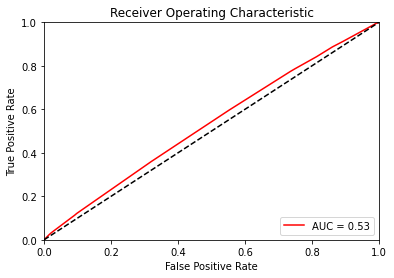

              precision    recall  f1-score   support

       False       0.89      0.51      0.65    126902
        True       0.13      0.53      0.20     16930

    accuracy                           0.51    143832
   macro avg       0.51      0.52      0.43    143832
weighted avg       0.80      0.51      0.60    143832

[0.26972529 0.52244355 0.20783115]


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
import sklearn.metrics as metrics


# Split our data into features and labels
X = Closing_Odds[training_columns]
y = Closing_Odds['condition']

# Split into train/test sets with 20% of games as testing and 80% as training

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Let's take a classic Decision Tree for now. Explainable, handles classs imbalance and intuitive 
model = DecisionTreeClassifier(random_state = 77, class_weight='balanced', max_depth=4)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities for AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc:.4f}')

pl.title('Receiver Operating Characteristic')
pl.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
pl.legend(loc = 'lower right')
pl.plot([0, 1], [0, 1],color = 'black',linestyle='--')
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.ylabel('True Positive Rate')
pl.xlabel('False Positive Rate')
pl.show()

# Also, print a classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(model.feature_importances_)

#### This model has an AUC of .535, and it correctly retrieves 64% of the games fulfilling the paper's condition. This is a great first step, and a gives us hope that with a better data pipeline, we can leverage more data (odds, mainly) into the training/testing processes to bolster these results in the future.

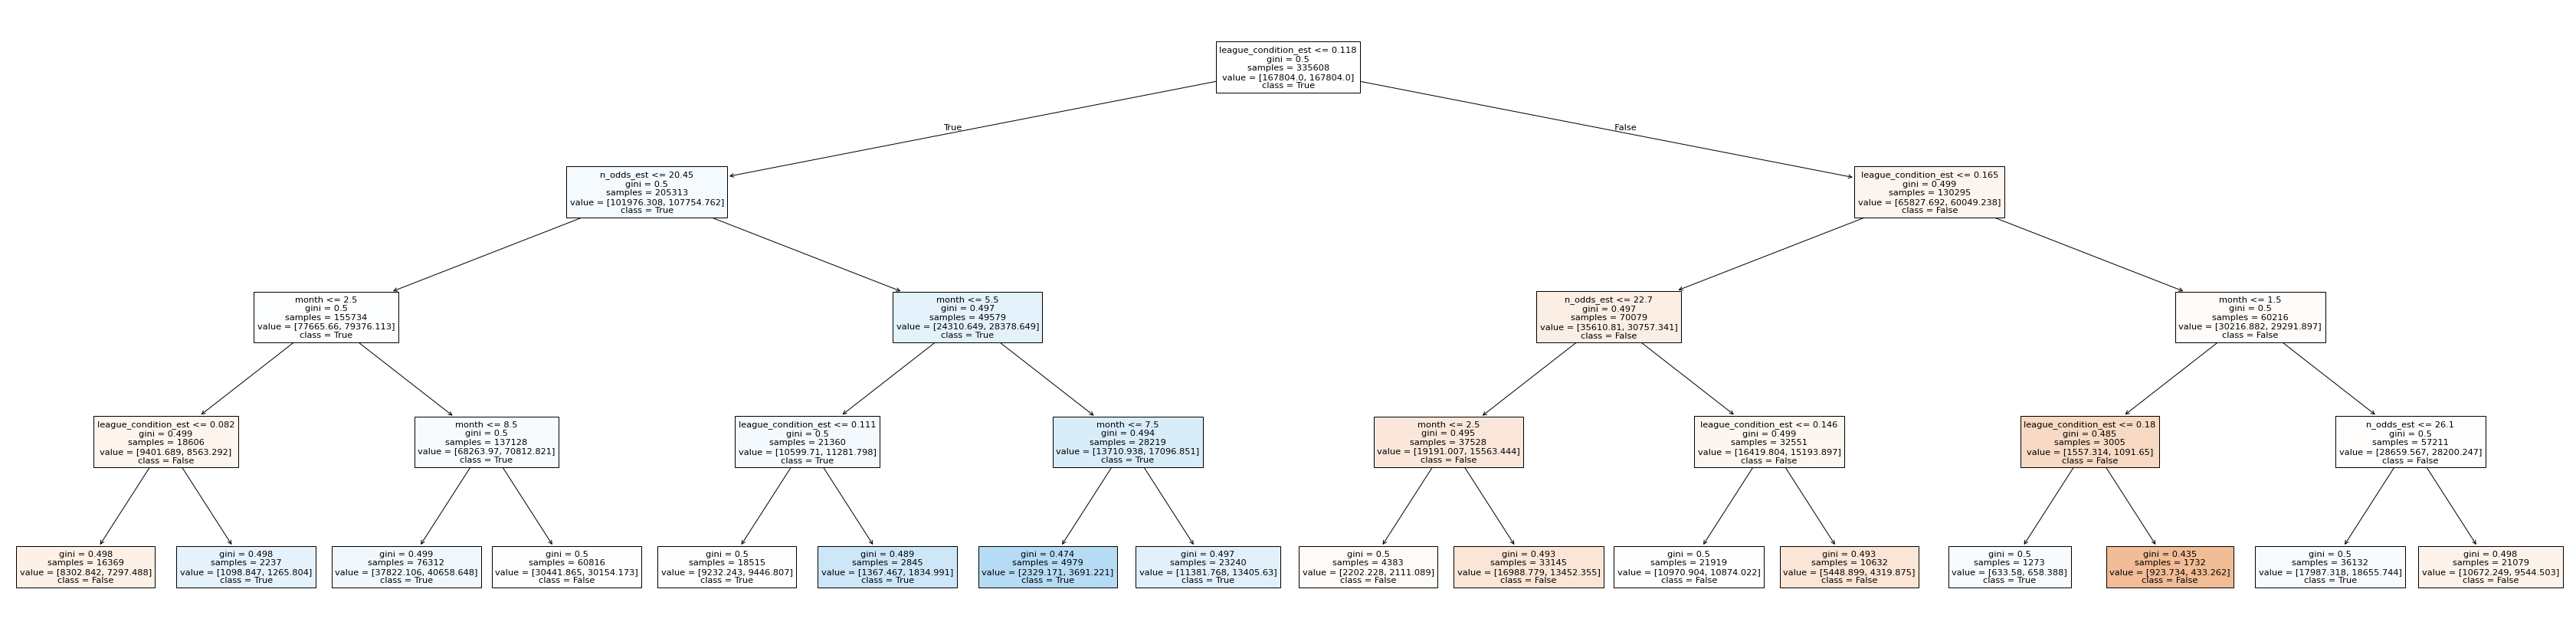

In [39]:
fig = pl.figure(figsize=(60,15))
_ = tree.plot_tree(model,feature_names=X.columns,class_names=['False','True'], filled=True)

## Conclusion :



This time, the model is even better, with better features, more explainability, and less complexity.

It might be beneficial to try other types of models, like XGBoost for example. I didn't want to take that route based on what you advised.

I did my best to follow your feedback, and still stay true to the original paper's vision, which is to stay away from the idea of trying to predict games' results and instead focus solely on bookmakers' odd distribution.

I hope you like it better this time.

In [40]:
.

SyntaxError: invalid syntax (Temp/ipykernel_6912/1933637684.py, line 1)

What Chatbots hinted at. I don't see anything that doesn't fall into 1 of 3 categories :
- I tried it
- It clashes with the idea of the paper, which is to stay as far as we can from trying to predict games' results
- It can't be done with our data

Also, most of them would fall in the "previous solution was too complicated, simplify" category. I would've maybe liked to try some, but I feared it would've meant going directly against what you advised me to do. 

Let me know if I missed something, I will listen carefully to your feedback.

### Team Performance Features
##### Historical Win/Loss/Draw Rates:

Home Team Win Rate

Away Team Win Rate

Home Team Draw Rate

Away Team Draw Rate


##### Goals Scored and Conceded:

Average Goals Scored (Home)

Average Goals Conceded (Home)

Average Goals Scored (Away)

Average Goals Conceded (Away)

### Recent Form:

Home Team Recent Form

Away Team Recent Form

### Head-to-Head Features
##### Head-to-Head Win/Loss/Draw Rates:

Home Team Win Rate vs. Away Team

Away Team Win Rate vs. Home Team

Draw Rate

##### Head-to-Head Goals Scored and Conceded:

Average Goals Scored by Home Team vs. Away Team 

Average Goals Conceded by Home Team vs. Away Team

Average Goals Scored by Away Team vs. Home Team

Average Goals Conceded by Away Team vs. Home Team



### League-Specific Features
##### League Performance:

Home Team League Position

Away Team League Position

League Average Goals

##### League Strength:

League Strength Indicator: A metric indicating the overall strength of the league (e.g., average goals per match, win/loss rates).


### Time-Based Features
##### Time Since Last Match:

Days Since Last Match (Home)

Days Since Last Match (Away)

##### Match Timing:

Day of the Week

Month



### Team-Specific Features
##### Home/Away Performance:

Home Team Home Performance

Away Team Away Performance


##### Team Strength Indicators:

Home Team Strength : composite metric indicating the overall strength of the home team (e.g., based on historical performance, goals scored, etc.)
Away Team Strength


### Features I tried to implement, but didn't keep in the end. Either because of how little variance they explained, or because I felt it was already too complicated. I know it's still steep, but I really tried to simplify as much as I could.

### #4 : Team recent form through winrate difference

Theory : Some games are expected to be close, some aren't. This has a tremendous impact on odds distribution. On one hand, the favorite will have odds around 1 and the other around 3, 10, sometimes 50+. On the other hand, if both teams get assigned odds around 2 or 3, indicating a close game, there might be very little leeway for our strategy to work, because of the little variance allowed to us.

What if we could spot games between unbalanced teams, and check if our condition applies to those more or not ?
For that, we will compute teams' last 5 games' results, translate it into a score (+3 for a win, -3 for a loss). And then compute the difference between the Home team score and the Away team score. This will give us a feature, ranging from -30 to +30, with -30s being unbalanced game in favor of the away team, +30s for the home team, and ~0s for close games. 

Let's see where it leads us !

In [ ]:
def away_team_last_5_wr(df):

    last_5_wr = []

    # Dictionary to track the last 5 games of each team
    team_history = {}

    for _, row in df.iterrows():
        away_team = row['away_team']
        result = row['result']

        # Initialize team history if not present
        if away_team not in team_history:
            team_history[away_team] = []

        # Calculate score for the last 5 games
        recent_results = team_history[away_team]
        if len(recent_results) > 0:
            wr = 3*sum(recent_results)
            
        else:
            wr = 0
        last_5_wr.append(wr)

        if len(recent_results) == 5:
            recent_results.pop(0)  
        recent_results.append(result)

    return pd.Series(last_5_wr, name='away_last_5_wr')

Last_5_A_WR = away_team_last_5_wr(Closing_Odds)

In [ ]:
def home_team_last_5_wr(df):

    last_5_wr = []

    # Dictionary to track the last 5 games of each home team
    team_history = {}

    for _, row in df.iterrows():
        home_team = row['home_team']
        result = row['result']

        # Initialize team history if not present
        if home_team not in team_history:
            team_history[home_team] = []

        # Calculate score for the last 5 games
        recent_results = team_history[home_team]
        if len(recent_results) > 0:
            wr = 3*sum(recent_results)

            
        else:
            wr = 0
        last_5_wr.append(wr)

        # Update the team's history with the current game result
        if len(recent_results) == 5:
            recent_results.pop(0)  # Remove the oldest result
        recent_results.append(result)

    return pd.Series(last_5_wr, name='home_last_5_wr')

Last_5_H_WR = home_team_last_5_wr(Closing_Odds)

In [ ]:
Score_Feature = Last_5_H_WR-Last_5_A_WR
Score_Feature

In [ ]:
Closing_Odds['score_feature']=Score_Feature

In [ ]:
X = list(sorted(Closing_Odds['score_feature'].unique()))
Y = Closing_Odds.groupby('score_feature')['condition'].describe()["count"]
Y2 = Closing_Odds[Closing_Odds['condition']==True].groupby('score_feature')['condition'].describe()["count"]

ratios = (Y2 / Y) * 100

fig, axes = pl.subplots(1, 2, figsize=(12, 6))

axes[0].bar(x=X, height=Y, width=2, align='center')
axes[0].bar(x=X, height=Y2, width=1.5, align='center')
axes[0].set_title("Games per difference in recent form (Score)")


axes[1].bar(x=X, height=ratios, width=2, color='grey', align='center')
axes[1].set_title("% of 'good' games per Score difference")


pl.tight_layout()
pl.show()

Unfortunately, our condition isn't tied at all to our metric. Our hypothesis is rejected.

### #5 : Teams' last 5 performances (odds estimators)

Most of our betting strategy revolves around the available odds. Unfortunately, we can't access future games' odds, because of how time works. 

Instead, we could try to estimate bookmakers' future odds based on what they did recently for each Home/Away teams.

Let's do an example first. Here are Marseille's last 5 recorded away games, with their opponent and the associated odds for their win.
Based on this data, what if we estimate their last away game average odd to be the average of the 5 previous ones ? Would we be off the mark ? Way off ? Or somewhat close ? Let's do it by hand this time. 

In [ ]:
Closing_Odds = Closing_Odds.sort_values(by=['match_id'])

In [ ]:
Closing_Odds[Closing_Odds["away_team"]=="Marseille"][["home_team","away_team","match_date","avg_odds_away_win"]].tail(6)

In [ ]:
Closing_Odds[Closing_Odds["away_team"]=="Marseille"][["home_team","away_team","match_date","avg_odds_away_win"]].tail(6)[:5]['avg_odds_away_win'].mean()

Not too bad. It also relies heavily on the opponent, as one could've guessed. Maybe we will have to include that in the future.

In [ ]:
def away_team_last_5_odds(df):

    last_5_odds = []

    # Dictionary to track the last 5 games of each team (away only)
    team_history = {}

    for _, row in df.iterrows():
        away_team = row['away_team']
        odd = row['avg_odds_away_win']

        # Initialize team history if not present
        if away_team not in team_history:
            team_history[away_team] = []

        # Calculate win rate for the last 5 games
        recent_odds = team_history[away_team]

        if len(recent_odds) > 0:
            avg_odds = sum(recent_odds)/len(recent_odds)
            
        else:
            avg_odds = 0
        last_5_odds.append(avg_odds)

        # Update the team's history with the current game result
        if len(recent_odds) == 5:
            recent_odds.pop(0)  # Remove the oldest result
        recent_odds.append(odd)

    return pd.Series(last_5_odds, name='away_last_5_odds')

Last_5_A_Odds = away_team_last_5_odds(Closing_Odds)

In [ ]:
Closing_Odds['avg_away_win_est'] = Last_5_A_Odds
Closing_Odds['avg_away_win_est'].describe()

In [ ]:
def home_team_last_5_odds(df):

    last_5_odds = []

    # Dictionary to track the last 5 games of each team (home only)
    team_history = {}

    for _, row in df.iterrows():
        home_team = row['home_team']
        odd = row['avg_odds_home_win']

        # Initialize team history if not present
        if home_team not in team_history:
            team_history[home_team] = []

        # Calculate win rate for the last 5 games
        recent_odds = team_history[home_team]

        if len(recent_odds) > 0:
            avg_odds = sum(recent_odds)/len(recent_odds)
            
        else:
            avg_odds = 0
        last_5_odds.append(avg_odds)

        # Update the team's history with the current game result
        if len(recent_odds) == 5:
            recent_odds.pop(0)  # Remove the oldest result
        recent_odds.append(odd)

    return pd.Series(last_5_odds, name='home_last_5_odds')

Last_5_H_Odds = home_team_last_5_odds(Closing_Odds)

In [ ]:
Closing_Odds['avg_home_win_est'] = Last_5_H_Odds
Closing_Odds['avg_home_win_est'].describe()

### #6: Recent form (Goal Average)

If winrate aren't cutting it, maybe goal average will. To test this new hypothesis, we'll add a feature that contains the difference in goals scored-conceded for both teams, to assess who's going into this new game better prepared.

The idea is similar to the previous one : if a team scores more and concedes less, they are probably favorites, and therefore it has an impact on the odds that will be distributed.

In [ ]:
def home_team_last_5_ga(df):

    last_5_ga = []

    # Dictionary to track the last 5 games of each home team
    team_history = {}

    for _, row in df.iterrows():
        home_team = row['home_team']
        result = row['home_score']-row['away_score']

        # Initialize team history if not present
        if home_team not in team_history:
            team_history[home_team] = []

        # Calculate win rate for the last 5 games
        recent_results = team_history[home_team]
        if len(recent_results) > 0:
            ga = sum(recent_results)

            
        else:
            ga = 0
        last_5_ga.append(ga)

        # Update the team's history with the current game result
        if len(recent_results) == 5:
            recent_results.pop(0)  # Remove the oldest result
        recent_results.append(result)

    return pd.Series(last_5_ga, name='home_last_5_ga')

Last_5_H_GA = home_team_last_5_ga(Closing_Odds)

In [ ]:
def away_team_last_5_ga(df):

    last_5_ga = []

    # Dictionary to track the last 5 games of each home team
    team_history = {}

    for _, row in df.iterrows():
        away_team = row['away_team']
        result = row['away_score']-row['home_score']

        # Initialize team history if not present
        if away_team not in team_history:
            team_history[away_team] = []

        # Calculate win rate for the last 5 games
        recent_results = team_history[away_team]
        if len(recent_results) > 0:
            ga = sum(recent_results)

            
        else:
            ga = 0
        last_5_ga.append(ga)

        # Update the team's history with the current game result
        if len(recent_results) == 5:
            recent_results.pop(0)  # Remove the oldest result
        recent_results.append(result)

    return pd.Series(last_5_ga, name='away_last_5_ga')

Last_5_A_GA = away_team_last_5_ga(Closing_Odds)

In [ ]:
Closing_Odds['Home_GA'] = Last_5_H_GA
Closing_Odds['Away_GA'] = Last_5_A_GA

In [ ]:
X = list(sorted(Closing_Odds['Home_GA'].unique()))
Y = Closing_Odds.groupby('Home_GA')['condition'].describe()["count"]
Y2 = Closing_Odds[Closing_Odds['condition']==True].groupby('Home_GA')['condition'].describe()["count"]

ratios = (Y2 / Y) * 100

fig, axes = pl.subplots(1, 2, figsize=(12, 6))

axes[0].bar(x=X, height=Y, width=.7, align='center')
axes[0].set_title("N° games per difference in GA for Home team")


axes[1].bar(x=X, height=ratios, width=.7, color='grey', align='center')
axes[1].set_title("% of 'good' games per GA difference")


pl.tight_layout()
pl.show()

In [ ]:
X = list(sorted(Closing_Odds['Away_GA'].unique()))
Y = Closing_Odds.groupby('Away_GA')['condition'].describe()["count"]
Y2 = Closing_Odds[Closing_Odds['condition']==True].groupby('Away_GA')['condition'].describe()["count"]

ratios = (Y2 / Y) * 100

fig, axes = pl.subplots(1, 2, figsize=(12, 6))

axes[0].bar(x=X, height=Y, width=.7, align='center')
axes[0].set_title("N° games per difference in GA for Away team")


axes[1].bar(x=X, height=ratios, width=.7, color='grey', align='center')
axes[1].set_title("% of 'good' games per GA difference")


pl.tight_layout()
pl.show()

This time, our metrics lead us to the expected conclusion. However, the fact that games with a |GA_difference| higher than 10 are so rare that this will never hold any weight in our model. It would've been great though.